# A Spike protein sequences embedding approach for pattern recognition analysis (part 2)

There are many approaches for representing protein sequences, that are sequences of letters (amino acids), using meaningful dense vector representation (i.e. their numerical embedding). In this notebook, we exploit the one provided by the output vector of LSTM layer in Keras.   

## Understanding LSTM Output

Recurrent Neural Networks (RNNs) are suitable to process sequential data where the ordering has a meaning, such as the case of our protein sequences, because they are able to learn and understand the relationship between the previous and current characters thanks to the **hidden state** that encodes the information about the previous inputs of our sequence. This ensures that at each time step the network has information of both the current input and the previous ones. However RNNs are affected by the "memory decay" problem caused by the vanishing gradient problem when training the network using back-propagation algorithm. As a consequence, dependencies between the first and last amino acid of a protein sequence will poorly be captured by the network. A network with *Long-Short-Term-Memory* cells, which take the place of "simple" neurons, tries to overcome this issue. In this case, each cell has 3 gates that allow a mechanism of addition and forgetting: they integrate the information from the previous cells with the new input and gives the possibility to decide which is the important information to keep. So, besides the memory decay for events far in time (*short-term memory*), these cells can memorize events far in the time or in a sequence in order to allow past information to be reinjected at a later time, selectively choosing the size of the *long-term memory* with this memory cell structure:

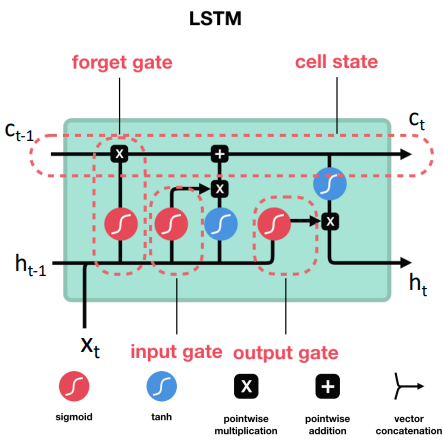

Roll-Out Representation of LSTM for each Time Step:

<img src="The%20Right%20Unrolled%20Network.png" alt="Drawing" style="width: 850px;"/>


LSTM can return different sets of results/states according to the given parameters. In this case we consider the LSTM default return value that gives as output the **hidden state**, $h_{t}$ at the **last time step**.

In particular, the output is a 2D array of real numbers. The first dimension is the number of samples (sequences) given to the LSTM layer; the second dimension is the dimensionality of the output space defined by the **units** parameter in Keras LSTM implementation. Therefore, each input sequence is represented by a 64-dimensional vector: each vector has 64 values that are the hidden state values at the last time steps of the corresponding 64 LSTM cells. In fact, the **units** parameter "intuitively" is just like the dimension of a dense layer. For instance, `model.add(Dense(64))` will have 64 neurons; `LSTM(units=64)` will be a layer of 64 "smart neurons" where each neuron is the first figure reported above and the output will be a vector of 64 dimensions for each input sequence data.  

In essence, the LSTM layer will contain multiple parallel LSTM units , structurally identical but each eventually "learning to remember" some different things and will output different hidden state values.

Now let us see all this in practice.

# Setup

In [1]:
#Modules
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter

#Modules to prepare protein sequences
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split


#Modules to build the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from keras.layers.embeddings import Embedding
from keras.layers import LSTM

from tensorflow import keras

#Dimensionality reduction methods
from sklearn.decomposition import PCA
import umap
from sklearn.manifold import TSNE

#Clustering
from sklearn.cluster import DBSCAN
from sklearn import metrics

Since the data is in fasta format, we can use **Bio.SeqIO.FastaIO**  library to read the dataset. Thus we define a function to read our fasta file:

In [3]:
def read_fasta(file_path, columns) :
    from Bio.SeqIO.FastaIO import SimpleFastaParser 
    with open("cov_all.fa") as fasta_file :  #Will close handle cleanly
        records = [] # create empty list
        for title, sequence in SimpleFastaParser(fasta_file):
            record = []
            title_splits=re.findall(r"[\w']+", title) # Data cleaning is needed
            
            record.append(title_splits[0])  #First values are ID ('append' adds element to a list)
            record.append(len(sequence)) #Second values are sequences lengths
            sequence = " ".join(sequence) #It converts into one line
            record.append(sequence) #Third values are sequences
                
            #Fourth column will contain the species
            if any(Sapientis in title_splits for Sapientis in ("Human","Homo sapiens","Homo")):
                record.append("Human")
            elif any(Chiroptera in title_splits for Chiroptera in ("Bat","bat")):
                record.append("Bat") #Bat
            elif any(Pholidota in title_splits for Pholidota in ("Pangolin","pangolin")):
                record.append("")#Pangolin
            else:
                record.append("Others")
                
    
            records.append(record)
            
    return pd.DataFrame(records, columns = columns) 

We have created a function that returns a dataframe based on our fasta file. Let us use this function:

In [4]:
data = read_fasta("cov_all.fa", columns=["id","sequence_length", "sequence", "animal"])

In [5]:
data.head()

,id,sequence_length,sequence,animal
0,YP_009724390,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
1,BCG52831,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
2,QKS65476,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
3,QKS65488,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human
4,QKS65608,1273,M F V F L V L L P L V S S Q C V N L T T R T Q ...,Human


In [6]:
#Remove rows with empty strings

data["animal"].replace("", np.nan, inplace=True)

data.dropna(subset = ["animal"], inplace=True)

As we have seen in the previous notebook, host species classes are imbalanced. In this work, we will train a neural network classifier to discriminate sequences according to their host species just using the simple undersampling method. Then we extract the output vector of LSTM layer in order to obtain numerical embedding of protein sequences. 

In [7]:
#First we shuffle data
shuffled_data =data.sample(frac=1, random_state=1).reset_index(drop=True) 
#random_state for reproducibility
#frac=1 specifies the fraction of rows to return in the random sample, so frac=1 means return all rows (in random order).

#Select subset dataset
grouped = shuffled_data.groupby('animal')
subset_data = (grouped.head(grouped.size().min())).reset_index(drop=True)

In [8]:
cnt = Counter(subset_data.animal)
print(cnt)

Counter({'Human': 260, 'Others': 260, 'Bat': 260})


In [9]:
#In order to create a list (it will be used later)
list_animal_counts=cnt.most_common()
type(cnt.most_common()) # list
list_animal_counts

[('Human', 260), ('Others', 260), ('Bat', 260)]

Using **LabelEncoder** from **sklearn.preprocessing**, we encode target labels with value between 0 and n_classes-1.

In [11]:
lb = LabelEncoder()
Y = lb.fit_transform(subset_data.animal) 

#To get mapping of label encoder
lb_name_mapping= dict(zip(lb.classes_, lb.transform(lb.classes_)))
print(lb_name_mapping) 

{'Bat': 0, 'Human': 1, 'Others': 2}


In [12]:
# Let us create a dataframe with only one column with labels (it will be used later) 
d = {'Labels':Y}
LabelDf=pd.DataFrame(d) 

The sequences have different lengths and Keras prefers inputs to be vectorized and all inputs to have the same length.

In [47]:
# maximum length of sequence, everything afterwards is discarded!
max_length = 350 
seqs=subset_data.sequence 
subset_data.sequence

0      M F V F L V L L P L V S S Q C V N L T T R T Q ...
1      M F V F L V L L P L V S S Q C V N L T T R T Q ...
2      M F V F L V L L P L V S S Q C V N L T T I T Q ...
3      M F V F L V L L P L V S S Q C V N L T T R T Q ...
4      M F V F L V L L P L V S S Q C V N L T T R T Q ...
                             ...                        
775    M F L T C F I L S F S L F C V S G D S I D T C ...
776    M K I L I L A F L A N L A K A Q E G C G I I S ...
777    M F F L F V V A L I P L V R S Q A N D C T Y S ...
778    M T L L M C L L M S L L I F V R G C D S Q F V ...
779    M L L I A F I L L P V V T A S R P F C L G R D ...
Name: sequence, Length: 780, dtype: object

The embedding neural network layer does not accept directly the sequences in the form of strings or list of strings. We have to vectorize each sequence by translating each token in the sequence to its index in the vocabulary.

In [48]:
#create the tokenizer
tokenizer = Tokenizer()
#fit the tokenizer
tokenizer.fit_on_texts(seqs)
#represent input data as symbol rank number sequences
X = tokenizer.texts_to_sequences(seqs)

print('symbol_index : ',tokenizer.word_index)

symbol_index :  {'l': 1, 's': 2, 'v': 3, 't': 4, 'n': 5, 'g': 6, 'a': 7, 'i': 8, 'f': 9, 'd': 10, 'q': 11, 'y': 12, 'p': 13, 'k': 14, 'e': 15, 'c': 16, 'r': 17, 'h': 18, 'm': 19, 'w': 20}


For sequences that are shorter than the maximum length, we will have to add paddings (empty tokens) to the sequences to make up the length.

In [49]:
padded_sequences = pad_sequences(X, maxlen=max_length, padding='post')
type(padded_sequences)

numpy.ndarray

# Training the LSTM network

Now we train the neural network to classify Spike protein sequences according to the category (host species) they belong to. Let us first set the number of classes and the amount of data used for training and testing:

In [50]:
#Set the number of classes
classes=3

We train the network on 95% of the training set, and use the remaining 5% as validation set to monitor the improvement of the network during the training process.

In [51]:
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, Y, test_size=0.05, shuffle=True, random_state=721)

In [58]:
#Set the dimension of embedding vectors
embedding_dim = 10 

#Create the model
model = Sequential()#1.Define a model
#With model.add() you add hidden layers.
model.add(Embedding(len(tokenizer.word_index)+1, embedding_dim, input_length=max_length, name='embeddings')) 
model.add(LSTM(units=64)) #Default parameters return last hidden state
model.add(Dropout(0.25))
model.add(Dense(64))
model.add(Dropout(0.3))
model.add(Dense(classes,activation='softmax')) 
#model.add(Dense(1,activation='sigmoid')) for binary classification problem
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embeddings (Embedding)      (None, 350, 10)           210       
                                                                 
 lstm_5 (LSTM)               (None, 64)                19200     
                                                                 
 dropout_8 (Dropout)         (None, 64)                0         
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 3)                 195       
                                                                 
Total params: 23,765
Trainable params: 23,765
Non-trai

In [59]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#2.compile the model
#binary_crossentropy for binary classification problem

In [60]:
history = model.fit(X_train, y_train,  batch_size=128, validation_data=(X_test, y_test),verbose=2, epochs=15) #3.fit the model

Epoch 1/15
6/6 - 13s - loss: 1.0980 - accuracy: 0.3185 - val_loss: 1.0926 - val_accuracy: 0.2821 - 13s/epoch - 2s/step
Epoch 2/15
6/6 - 5s - loss: 1.0914 - accuracy: 0.3590 - val_loss: 1.0851 - val_accuracy: 0.2821 - 5s/epoch - 898ms/step
Epoch 3/15
6/6 - 6s - loss: 1.0802 - accuracy: 0.5479 - val_loss: 1.0714 - val_accuracy: 0.7179 - 6s/epoch - 923ms/step
Epoch 4/15
6/6 - 5s - loss: 1.0589 - accuracy: 0.6424 - val_loss: 1.0376 - val_accuracy: 0.7179 - 5s/epoch - 896ms/step
Epoch 5/15
6/6 - 5s - loss: 1.0139 - accuracy: 0.6761 - val_loss: 0.9372 - val_accuracy: 0.7949 - 5s/epoch - 878ms/step
Epoch 6/15
6/6 - 5s - loss: 0.9211 - accuracy: 0.6883 - val_loss: 0.7106 - val_accuracy: 0.7949 - 5s/epoch - 889ms/step
Epoch 7/15
6/6 - 6s - loss: 0.8173 - accuracy: 0.6613 - val_loss: 0.6589 - val_accuracy: 0.6923 - 6s/epoch - 925ms/step
Epoch 8/15
6/6 - 5s - loss: 0.7477 - accuracy: 0.6464 - val_loss: 0.6197 - val_accuracy: 0.6923 - 5s/epoch - 883ms/step
Epoch 9/15
6/6 - 5s - loss: 0.6980 - accu

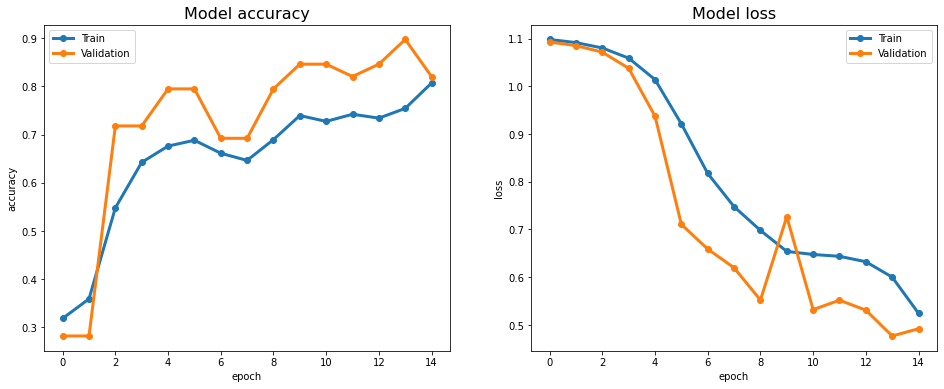

In [61]:
fig, (axis1, axis2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))

# summarize history for accuracy
axis1.plot(history.history['accuracy'], label='Train',linestyle='-', linewidth=3, marker="o")
axis1.plot(history.history['val_accuracy'], label='Validation', linestyle='-', linewidth=3, marker="o")
axis1.set_title('Model accuracy', fontsize=16)
axis1.set_ylabel('accuracy')
axis1.set_xlabel('epoch')
axis1.legend(loc='upper left')

# summarize history for loss
axis2.plot(history.history['loss'], label='Train',linestyle='-', linewidth=3, marker="o")
axis2.plot(history.history['val_loss'], label='Validation', linestyle='-', linewidth=3, marker="o")
axis2.set_title('Model loss', fontsize=16)
axis2.set_ylabel('loss')
axis2.set_xlabel('epoch')
axis2.legend(loc='upper right')
plt.show()

From a fast check of the model history, we can notice that during the 15 epochs the training and validation loss decreases while the training and validation accuracy increases and so we can say that, in these 15 epochs, our neural network is learning.

# Outputs of intermediate layers

Now we can extract the output of the intermediate layers of our neural network with the following lines of code. Let us first get the name of the layers:

In [62]:
for layer in model.layers:
    print(layer.name)

embeddings
lstm_5
dropout_8
dense_8
dropout_9
dense_9


Even though we have already seen this in the summary of the model and even though we are interested in the output vector of the LSTM layer, let us check which is the LSTM *input* shape. 

In [70]:
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('embeddings').output)
lstm_input = intermediate_layer_model(padded_sequences)
lstm_input.shape

TensorShape([780, 350, 10])

This is the input shape: 780 number of samples, 350 time steps (i.e. amino acids symbols) and each index is converted into a vector of size 10.  Such input shape is converted into the following:

In [71]:
intermediate_layer_model = keras.Model(inputs=model.input, outputs=model.get_layer('lstm_5').output)
lstm_output = intermediate_layer_model(padded_sequences)
lstm_output.shape

TensorShape([780, 64])

As we expected, we have obtained a 2D output array with the two dimensions respectively the number of sequences and the number of units in the LSTM. We are going to exploit the 64-dimensional sequences, extracted from the LSTM layer, as dense vector representation of the Spike protein sequences. Are these vectors carrying information about the initial sequences of amino acids symbols ? Let us use the dimensionality reduction methods to reveal this.

# Dimensionality reduction methods to visualize protein sequences embeddings

In [78]:
#This is needed to assign colors to each label of the plots
list_label=[]
for Name in lb_name_mapping:
    list_label.append(lb_name_mapping[Name])

list_animal=[]
for Name in lb_name_mapping:
    list_animal.append(Name)

Here we apply Principal Component Analysis (PCA), that projects the data on the eigenvectors of the covariance matrix and reduces the dimensionality while conserving as much as possibile the variation present in the data.

In [73]:
pca = PCA(n_components=2)
embedding_PCA = pca.fit_transform(lstm_output)

In [75]:
PrincipalComponents= pd.DataFrame(data=embedding_PCA, columns=['PC1','PC2'])
FinalDf_PCA=pd.concat([PrincipalComponents,LabelDf[['Labels']]],axis=1)  
print(FinalDf_PCA)

          PC1       PC2  Labels
0   -0.667304  0.088283       1
1   -0.667304  0.088283       1
2   -0.667304  0.088283       1
3   -0.667304  0.088283       1
4   -0.667304  0.088283       1
..        ...       ...     ...
775 -0.155449 -0.006383       0
776 -0.095288  0.025959       0
777  0.149257 -0.475841       0
778  0.014404 -0.309203       0
779  0.507056  0.092278       0

[780 rows x 3 columns]


In [76]:
Percentage_PC1=int(pca.explained_variance_ratio_[0]*100)
Percentage_PC2=int(pca.explained_variance_ratio_[1]*100)

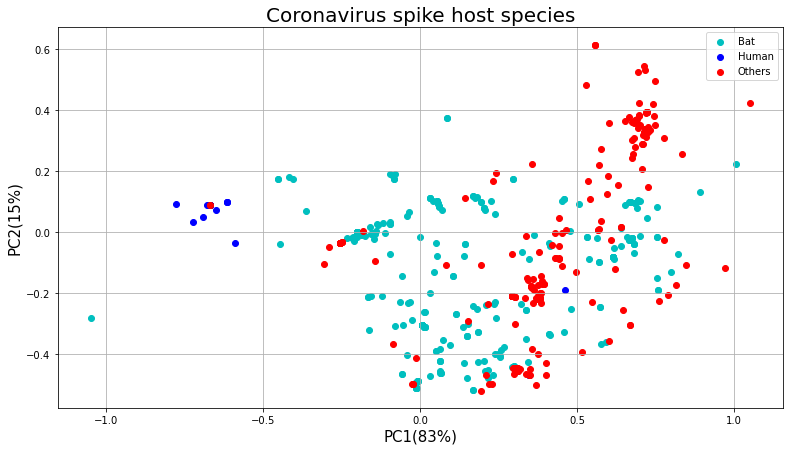

In [79]:
# Plot
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('PC1({}%)'.format(Percentage_PC1), fontsize=15)
ax.set_ylabel('PC2({}%)'.format(Percentage_PC2), fontsize=15)
ax.set_title('Coronavirus spike host species', fontsize=20)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_PCA['Labels'] == label
    ax.scatter(FinalDf_PCA.loc[indicesToKeep,'PC1'],FinalDf_PCA.loc[indicesToKeep,'PC2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

Now we can use dimensionality reduction methods that aim to conserve local neighborhood structure of the starting high dimensional space in a lower-dimensional space. They are based on a network description of space: we can consider the nodes as our samples and the links as the mutual distance. Let us start with umap for which the k-neighbors, whose structure has to be preserved, varies from node to node.

In [80]:
number_neighbors=100 #Try 100 15 50
reducer = umap.UMAP(n_neighbors=number_neighbors)#default=n_neighbors=15,metic="euclidian",min_dist=0.1,spread=1.0.
embedding_UMAP = reducer.fit_transform(lstm_output)

UMAPComponents= pd.DataFrame(data=embedding_UMAP, columns=['UMAP 1','UMAP 2'])
FinalDf_UMAP=pd.concat([UMAPComponents,LabelDf[['Labels']]],axis=1)  
FinalDf_UMAP

,UMAP 1,UMAP 2,Labels
0,37.679626,-22.476809,1
1,38.682613,-23.249775,1
2,38.418949,-23.482080,1
3,38.038944,-21.621248,1
4,38.865452,-23.188297,1
...,...,...,...
775,12.125868,0.029358,0
776,11.773099,0.160054,0
777,6.870847,-3.239237,0
778,9.170752,-3.352685,0


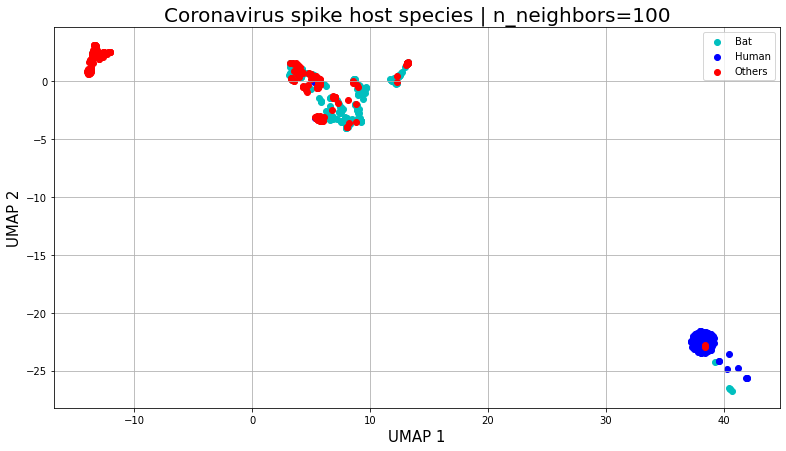

In [81]:
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.set_title('Coronavirus spike host species | n_neighbors={}'.format(number_neighbors), fontsize=20)
#plt.xlim(-31,-28)
#plt.ylim(4,6)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_UMAP['Labels'] == label
    ax.scatter(FinalDf_UMAP.loc[indicesToKeep,'UMAP 1'], FinalDf_UMAP.loc[indicesToKeep,'UMAP 2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

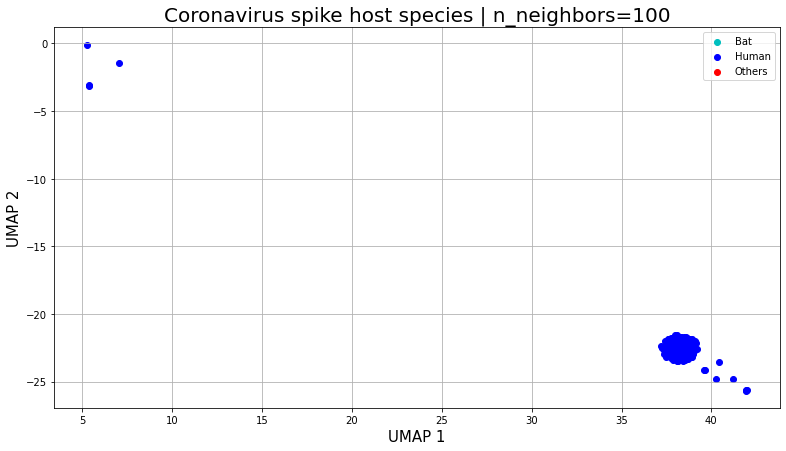

In [82]:
#If you want to visualize only a class, for example humans.

# Selecting rows by value in a floating point column in pandas
Subset_FinalDf_UMAP=FinalDf_UMAP[np.isclose(FinalDf_UMAP['Labels'], 1)]
Subset_FinalDf_UMAP

Subset_FinalDf_UMAP_Bat_Humans=FinalDf_UMAP.loc[FinalDf_UMAP['Labels'].isin([0,1])]
Subset_FinalDf_UMAP_Humans_Others=FinalDf_UMAP.loc[FinalDf_UMAP['Labels'].isin([1,2])]

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('UMAP 1', fontsize=15)
ax.set_ylabel('UMAP 2', fontsize=15)
ax.set_title('Coronavirus spike host species | n_neighbors={}'.format(number_neighbors), fontsize=20)
#plt.xlim(-5,10)

colors=['c','b','r','y']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_UMAP['Labels'] == label
    ax.scatter(Subset_FinalDf_UMAP.loc[indicesToKeep,'UMAP 1'], Subset_FinalDf_UMAP.loc[indicesToKeep,'UMAP 2'], c= color)
leg=ax.legend(list_animal)
ax.grid()

Finally, let us apply t-SNE method that, similarly to umap, is based on a network description of our space and aims to preserve the local neighborhood structure but in this case the number of neighbors is fixed for each sample point.

In [91]:
perplexity_value=100 #Try 5, 30, 50 and 100 
embedding_TSNE = TSNE(n_components=2, perplexity=perplexity_value, init='random').fit_transform(lstm_output)
# It takes some time . 

TSNEComponents= pd.DataFrame(data=embedding_TSNE, columns=['TSNE 1','TSNE 2'])
FinalDf_TSNE=pd.concat([TSNEComponents,LabelDf[['Labels']]],axis=1)  
FinalDf_TSNE

,TSNE 1,TSNE 2,Labels
0,-14.119285,7.946134,1
1,-13.079364,9.169557,1
2,-12.181904,9.137225,1
3,-14.353046,9.449877,1
4,-12.892240,9.492345,1
...,...,...,...
775,-0.501500,-3.213125,0
776,-0.218434,-3.168785,0
777,3.406710,-7.957315,0
778,2.102828,-6.905372,0


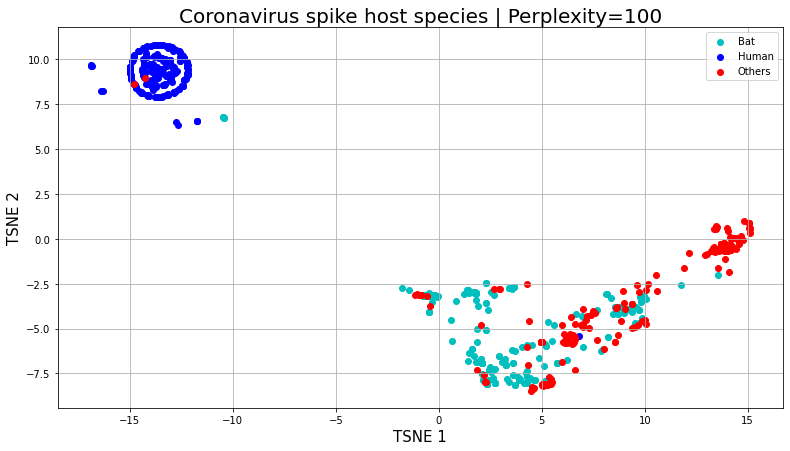

In [92]:
fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE 1', fontsize=15)
ax.set_ylabel('TSNE 2', fontsize=15)
ax.set_title('Coronavirus spike host species | Perplexity={}'.format(perplexity_value), fontsize=20)
#plt.xlim(20,28)

colors=['c','b','r','y','k']
for label,color in zip(list_label,colors):
    indicesToKeep = FinalDf_TSNE['Labels'] == label
    ax.scatter(FinalDf_TSNE.loc[indicesToKeep,'TSNE 1'], FinalDf_TSNE.loc[indicesToKeep,'TSNE 2'], c= color)
leg=ax.legend(list_animal)
ax.grid(True)

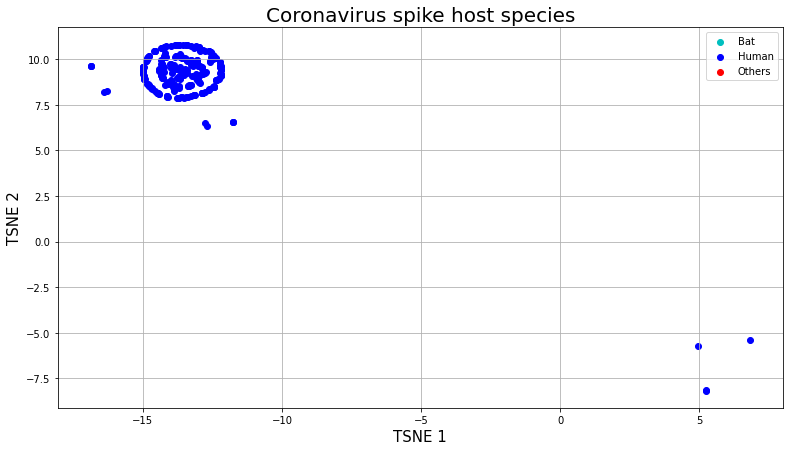

In [93]:
#If you want to visualize only a class, for example humans.

# Selecting rows by value in a floating point column in pandas
Subset_FinalDf_TSNE=FinalDf_TSNE[np.isclose(FinalDf_TSNE['Labels'], 1)]

fig= plt.figure(figsize=(13,7))
ax= fig.add_subplot(1,1,1)
ax.set_xlabel('TSNE 1', fontsize=15)
ax.set_ylabel('TSNE 2', fontsize=15)
ax.set_title('Coronavirus spike host species', fontsize=20)

colors=['c','b','r','y']
for label,color in zip(list_label,colors):
    indicesToKeep = Subset_FinalDf_TSNE['Labels'] == label
    ax.scatter(Subset_FinalDf_TSNE.loc[indicesToKeep,'TSNE 1'], Subset_FinalDf_TSNE.loc[indicesToKeep,'TSNE 2'], c= color)
leg=ax.legend(list_animal)
ax.grid() 

From the dimensionality reduction methods plots we notice firstly that the regular shape of the "main island" of human sequences in t-SNE and UMAP plots is conserved also by exploiting the output vector of the LSTM layer as protein sequences embedding. Then let us compare the plots of the previous notebook embedding method (i.e. the sequence embedding as the average amino acids embeddings) with the ones obtained here:

<table style="width:100%">
    <tr>
        <td><img src="PCAHumans260Bats260Others260.png"></td>
        <td><img src="PCAVectorLSTMOutput.png" ></td>
    </tr>
    <tr>
        <td colspan="2"><center>Figure 1: PCA plot of Spike protein sequences using the average amino acids embeddings (left hand side plot) and the LSTM output vector (right hand side plot).</center></td>
    </tr>
</table>

<table style="width:100%">
    <tr>
        <td><img src="UMAPHumans260Bats260Others260N100.png"></td>
        <td><img src="UMAPVectorLSTM.png" ></td>
    </tr>
    <tr>
        <td colspan="2"><center>Figure 2: UMAP plot of Spike protein sequences using the average amino acids embeddings (left hand side plot) and the LSTM output vector (right hand side plot).</center></td>
    </tr>
</table>

<table style="width:100%">
    <tr>
        <td><img src="TSNEHumans260Bats260Others260P100.png"></td>
        <td><img src="TSNEVectorLSTM.png" ></td>
    </tr>
    <tr>
        <td colspan="2"><center>Figure 3. tSNE plot of Spike protein sequences using the average amino acids embeddings (left hand side plot) and the LSTM output vector (right hand side plot).</center></td>
    </tr>
</table>

From figure 1 we notice that PCA method works better with the output vector of LSTM as protein sequences embedding: the percentage of variation accounted for by the first principal component is higher and this is reflected into the plot where human sequences make a cloud that is clearly separated from animal protein sequences along PC1 direction (apart from some overlapping points). For what concerns bat and other animals classes, the first impression is that they are mixed. But if we look carefully, we can notice that there is a higher density of other animals protein sequences in the right hand side of the PCA plot and far from the humans, while instead bat protein sequences cloud has a higher density closer to the human cluster. This characteristic is conserved also for the UMAP and TSNE plots.    

Finally, besides the last observation, while the UMAP plots do not show great differences between each other, the t-SNE plots in figure 3 are instead characterized by an important difference: the protein sequences embeddings based on the LSTM output vector reveal a much higher distiction between humans and animals characterized by a larger gap between human and animals clouds in the embedding space (apart from some red dots that overlap over the blue human island and some bat human sequences that are particularly near to humans).  

# Conclusions

Hence, some improvements come out when using the output of LSTM layer (that is part of a neural network classifier) as protein sequences embedding. This could be due to the fact that the first method, that considers the average of the amino acids embeddings as whole protein sequence embedding, has the unavoidable drawback that does not catch changings in amino acids positions, i.e. sequences with the same amino acids frequency but which are positioned in different ways will have the same embedding representation, leading to more overlapping cases. However, typically Spike protein sequences (and in general all the proteins of the same family) are made by more conserved blocks/patterns (the so called _motifs_) and the remaining part that differs across species and that could be seen as a "background". So it is difficult to find just shuffling of symbols. Hence, the first method must not be totally discarded. Anyway, both methods try to embed information from our sequences: the first one into the embedding vectors of the amino acids; the second one the sequence information is carried by the hidden states values of the LSTM cells that, as said at the beginning, are capable of "learning to remember" some different things of our proteins. Then it is a matter of "trials and errors" (also by changing the neural network hyperparameters) in order to see which is the embedding method that best cooks the data into a numerical representation.

# References

1. https://medium.com/deep-learning-with-keras/lstm-understanding-output-types-e93d2fb57c77
2. https://keras.io/getting_started/faq/#how-can-i-obtain-the-output-of-an-intermediate-layer-feature-extraction

Helpful StackExchange posts to understand what the **units** parameter means:

3. [Understanding LSTM units vs. cells](https://stats.stackexchange.com/questions/241985/understanding-lstm-units-vs-cells)
4. [In Keras, what exactly am I configuring when I create a stateful `LSTM` layer with N `units`?](https://stackoverflow.com/questions/44273249/in-keras-what-exactly-am-i-configuring-when-i-create-a-stateful-lstm-layer-wi#:~:text=Basically%2C%20the%20unit%20means%20the,be%20unit%20%2Dlength%20as%20well.)
5. [What is the meaning of "The number of units in the LSTM cell"?](https://datascience.stackexchange.com/questions/12964/what-is-the-meaning-of-the-number-of-units-in-the-lstm-cell)